# Algorithm comparison

The computations below compares fits to the same simulated data using two different algorithms, orthogonal distance regression (ODR) and least-squares (LSQ).

In [1]:
import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

from scipy import odr
from scipy.optimize import least_squares
from scipy.stats import cumfreq, chi2, norm, probplot

from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

from thztools.thztools import thzgen, noiseamp, costfunlsq

## Simulate set of noisy waveforms

In [2]:
n = 256     # Number of samples
ts = 0.05   # Sampling time [ps]
t0 = 2.5    # Peak pulse time [ps]
fs = 1 / ts # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2   # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3    # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0    # RNG seed
rng = default_rng(seed)

In [3]:
n_sim = 250

mu, t = thzgen(n, ts, t0)
sigma = noiseamp(sigma_parms, mu, ts)

x = mu + sigma * rng.standard_normal((n_sim, n))
y = mu + sigma * rng.standard_normal((n_sim, n))

The transfer function model function `tf_model` returns
 $$ H(\mathbf{\theta}; \omega) = \theta_0\exp(i\omega\theta_1),$$
 which rescales the input by $\theta_0$ and shifts it by $\theta_1$ (using the $-i\omega t$ sign convention). In the simulations, $\theta_0 = 1$ and $\theta_1 = 0$. The time-domain response function `td_model` applies this transfer function to a signal vector $x(t)$ for a given $\mathbf{\theta}$ and returns the resulting $y(t)$, as shown in the second cell for $\theta_0 = 0.5, \theta_1 = 1.0$.

In [4]:
def tf_model(_p, _w):
    return _p[0] * np.exp(-1j * _w * _p[1])

f = rfftfreq(n, ts)
def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y

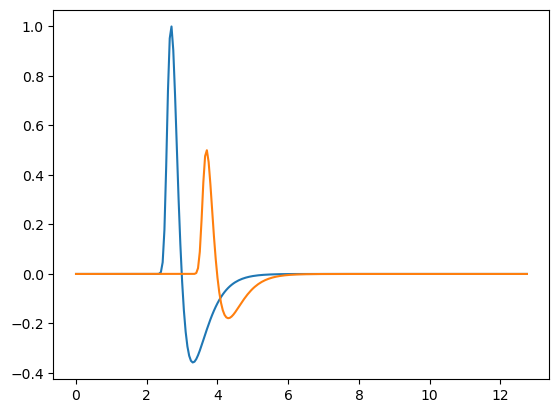

In [5]:
plt.plot(t, mu)
plt.plot(t, td_model((0.5, 1), mu))
plt.show()

## Fits with the ODR algorithm

In [6]:
%%time

p_odr = np.empty((2, n_sim))
resnorm_odr = np.empty((n_sim,))
epsilon_odr = np.empty((n, n_sim))
delta_odr = np.empty((n, n_sim))
sigma_odr = np.empty((2, n_sim))

model = odr.Model(td_model)

for i in range(n_sim):
    data = odr.RealData(x[i, :], y=y[i, :], sx=sigma, sy=sigma)
    fit = odr.ODR(data, model, beta0=(1, 0))
    result = fit.run()
    p_odr[:, i] = result.beta
    epsilon_odr[:, i] = result.eps
    delta_odr[:, i] = result.delta
    resnorm_odr[i] = result.sum_square
    sigma_odr[:, i] = result.sd_beta
    if not result.info < 4:
        print(f"Fit did not converge at i = {i}")

cf_odr = cumfreq(resnorm_odr, 1000, defaultreallimits=(0, 1000))
gof_odr = cf_odr.lowerlimit + np.linspace(0, cf_odr.binsize * cf_odr.cumcount.size,
                          cf_odr.cumcount.size)
ecdf_odr = cf_odr.cumcount / n_sim

CPU times: user 1.11 s, sys: 61.5 ms, total: 1.18 s
Wall time: 836 ms


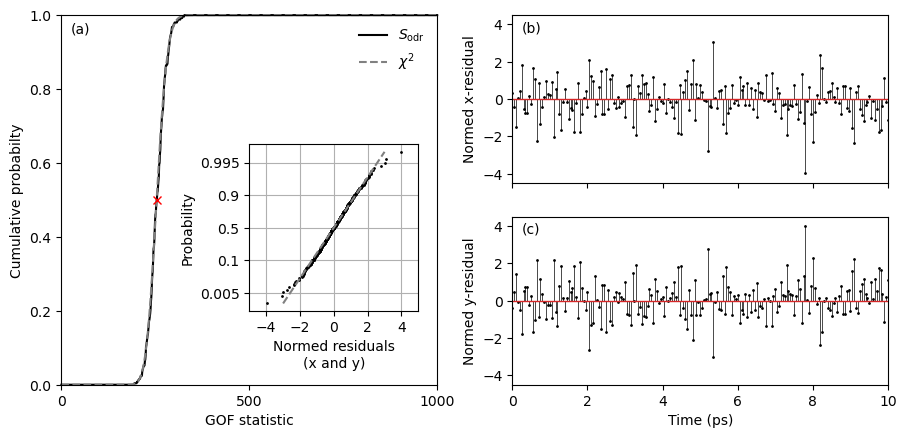

In [7]:
# Find the index of the median value
i_show = np.argsort(resnorm_odr)[len(resnorm_odr) // 2]
norm_res_eps = np.sqrt(512 / 254) * epsilon_odr[:, i_show] / sigma
norm_res_delta = np.sqrt(512 / 254) * delta_odr[:, i_show] / sigma
osm, osr = probplot(np.concatenate((norm_res_eps, norm_res_delta)), fit=False)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic([["CDF", "x-res"], ["CDF", "y-res"]], figsize=(w, h))

# Panel (a)
axd["CDF"].plot(gof_odr, ecdf_odr, 'k-', label=r'$S_\mathrm{odr}$', clip_on=False)
axd["CDF"].plot(gof_odr, chi2.cdf(gof_odr, n - 2), '--', c='gray', label=r'$\chi^2$', clip_on=False)
axd["CDF"].plot(np.median(resnorm_odr), 0.5, 'rx')

axd["CDF"].legend(loc='upper right', frameon=False)
axd["CDF"].text(0.025, 0.95, '(a)', transform=axd["CDF"].transAxes)

axd["CDF"].set_xlim(0, 1000)
axd["CDF"].set_ylim(0, 1)

axd["CDF"].set_xticks([0, 500, 1000])
axd["CDF"].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axd["CDF"].set_xlabel('GOF statistic')
axd["CDF"].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axd["CDF"].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-5, 5)
ins.set_ylim(norm.ppf([0.0005, 0.9995]))

ins.set_xticks(np.arange(-4, 4.5, 2))
ins.set_yticks(norm.ppf([ 0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed residuals\n(x and y)')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(t, norm_res_delta,
                                              linefmt = 'k-',
                                              markerfmt='.')
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.9, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
axd["x-res"].set_ylim(-4.5, 4.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_ylabel('Normed x-residual')

# Panel (c)
markerline, stemlines, baseline = axd["y-res"].stem(t, norm_res_eps,
                                              linefmt = 'k-',
                                              markerfmt='.')
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["y-res"].text(0.025, 0.9, '(c)', transform=axd["y-res"].transAxes)

axd["y-res"].set_xlim(0, 10)
axd["y-res"].set_ylim(-4.5, 4.5)

axd["y-res"].set_xlabel('Time (ps)')
axd["y-res"].set_ylabel('Normed y-residual')

plt.show()

In [8]:
print(f"Amplitude parameter estimates: "
      f"{np.mean(p_odr[0, :]):.3f} ± {np.std(p_odr[0, :]):.3f}")
print(f"Delay parameter estimates:     "
      f"({np.mean(1e3 * p_odr[1, :]):.1f} ± {1e3 * np.std(p_odr[1, :]):.1f}) fs")
print(f"Mean uncertainty estimate for amplitude parameter: "
      f"{np.mean(sigma_odr[0, :]):.4f}")
print(f"Mean uncertainty estimate for delay parameter:     "
      f"{1e3 * np.mean(sigma_odr[1, :]):.1f} fs")
print(f"Standard deviation of the amplitude parameter uncertainty estimate: "
      f"{np.std(sigma_odr[0, :]):.2g}")
print(f"Standard deviation of the delay parameter uncertainty estimate:     "
      f"{1e3 * np.std(sigma_odr[1, :]):.2g} fs")

Amplitude parameter estimates: 1.000 ± 0.002
Delay parameter estimates:     (-0.0 ± 0.4) fs
Mean uncertainty estimate for amplitude parameter: 0.0023
Mean uncertainty estimate for delay parameter:     0.4 fs
Standard deviation of the amplitude parameter uncertainty estimate: 0.0001
Standard deviation of the delay parameter uncertainty estimate:     0.049 fs


## Compare with fits using the LSQ algorithm
The LSQ algorithm takes nearly 2000 times longer than the ODR algorithm and yields comparable results, although the parameter estimates for $\theta_1$ show noticeable differences.

In [9]:
%%time

def lsq_model(_p, _w):
    return _p[0] * np.exp(1j * _w * _p[1])

p_tls = np.empty((2, n_sim))
resnorm_tls = np.empty((n_sim,))
residual_tls = np.empty((n, n_sim))
cv_tls = np.empty((2, 2, n_sim))
sigma_tls = np.empty((2, n_sim))

for i in range(n_sim):
    result = least_squares(lambda _p: costfunlsq(lsq_model, _p, x[i, :], y[i, :],
                                                 sigma, sigma, ts),
                           (1,0))
    p_tls[:, i] = result.x
    residual_tls[:, i] = result.fun
    resnorm_tls[i] = 2 * result.cost
    _, r = np.linalg.qr(result.jac)
    r_inv = np.linalg.inv(r)
    cv_tls[:, :, i] = r_inv @ r_inv.T
    sigma_tls[:, i] = np.sqrt(np.diag(cv_tls[:, :, i]))
    if not result.success:
        print(f"Fit did not converge at i = {i}")


CPU times: user 31min 2s, sys: 8min 29s, total: 39min 32s
Wall time: 5min 41s


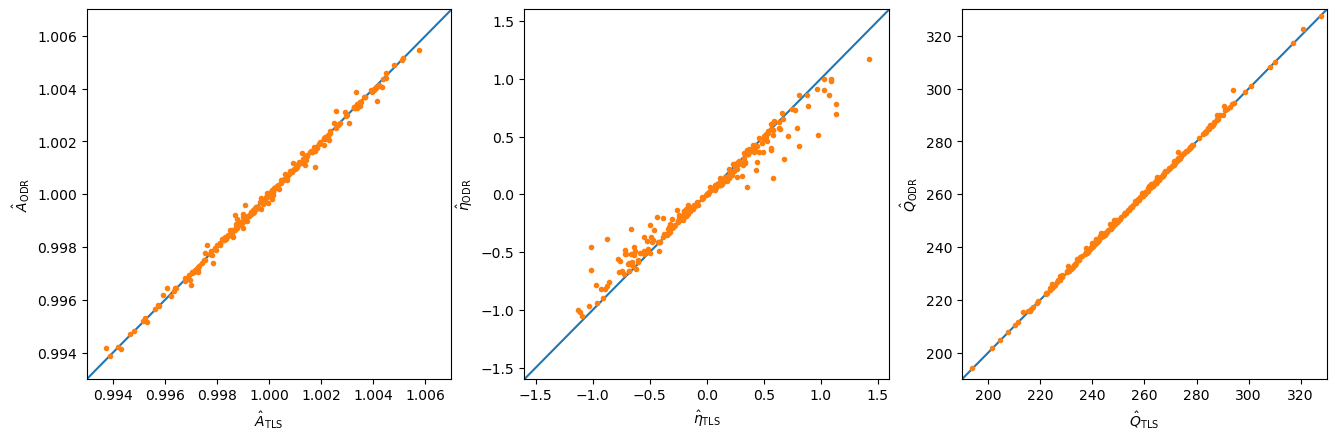

In [10]:
a_lim = (0.993, 1.007)
eta_lim = (-1.6, 1.6)
q_lim = (190, 330)

w, h = figaspect(0.3)

_, axs = plt.subplots(1, 3, figsize=(w, h))

axs[0].plot(a_lim, a_lim, '-')
axs[0].plot(p_tls[0,:], p_odr[0,:], '.')

axs[0].set_xlim(a_lim)
axs[0].set_ylim(a_lim)

axs[0].set_xlabel(r"$\hat{A}_\mathrm{TLS}$")
axs[0].set_ylabel(r"$\hat{A}_\mathrm{ODR}$")

axs[1].plot(eta_lim, eta_lim, '-')
axs[1].plot(1e3 * p_tls[1,:], 1e3 * p_odr[1,:], '.')

axs[1].set_xlim(eta_lim)
axs[1].set_ylim(eta_lim)

axs[1].set_xlabel(r"$\hat{\eta}_\mathrm{TLS}$")
axs[1].set_ylabel(r"$\hat{\eta}_\mathrm{ODR}$")

axs[2].plot(q_lim, q_lim, '-')
axs[2].plot(resnorm_tls, resnorm_odr, '.')

axs[2].set_xlim(q_lim)
axs[2].set_ylim(q_lim)

axs[2].set_xlabel(r"$\hat{Q}_\mathrm{TLS}$")
axs[2].set_ylabel(r"$\hat{Q}_\mathrm{ODR}$")


plt.show()

### Parameter estimate distributions

The cells below produce probability plots that show the parameter distributions in more detail. Both algorithms yield parameter estimates that are normally distributed around the true values, but the observed distribution for $\eta = \theta_1$ has a standard deviation that is slightly different from the average estimate given by the LSQ algorithm. The ODR algorithm yields accurate uncertainty estimates for both parameters.

In [11]:
osm_a_odr, osr_a_odr = probplot(p_odr[0, :], fit=False)
osm_eta_odr, osr_eta_odr = probplot(p_odr[1, :], fit=False)
osm_a_tls, osr_a_tls = probplot(p_tls[0, :], fit=False)
osm_eta_tls, osr_eta_tls = probplot(p_tls[1, :], fit=False)

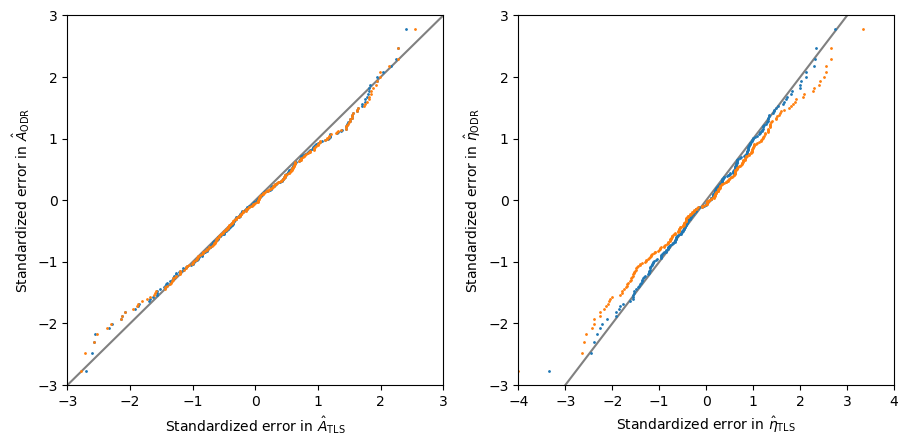

In [12]:
w, h = figaspect(0.45)

_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot((-4.5, 4.5), (-4.5, 4.5), c="gray")
axs[0].plot((osr_a_odr - 1) / np.mean(sigma_odr[0, :]), osm_a_odr, '.', ms=2)
axs[0].plot((osr_a_tls - 1) / np.mean(sigma_tls[0, :]), osm_a_tls, '.', ms=2)

axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)

axs[0].set_xlabel(r"Standardized error in $\hat{A}_\mathrm{TLS}$")
axs[0].set_ylabel(r"Standardized error in $\hat{A}_\mathrm{ODR}$")

axs[1].plot((-4.5, 4.5), (-4.5, 4.5), c="gray")
axs[1].plot(osr_eta_odr / np.mean(sigma_odr[1, :]), osm_eta_odr, '.', ms=2)
axs[1].plot(osr_eta_tls / np.mean(sigma_tls[1, :]), osm_eta_tls, '.', ms=2)

axs[1].set_xlim(-4, 4)
axs[1].set_ylim(-3, 3)

axs[1].set_xlabel(r"Standardized error in $\hat{\eta}_\mathrm{TLS}$")
axs[1].set_ylabel(r"Standardized error in $\hat{\eta}_\mathrm{ODR}$")

plt.show()

### Parameter uncertainty estimates

The parameter uncertainty estimates obtained with the ODR algorithm exhibit much larger variation than with the LSQ algorithm.

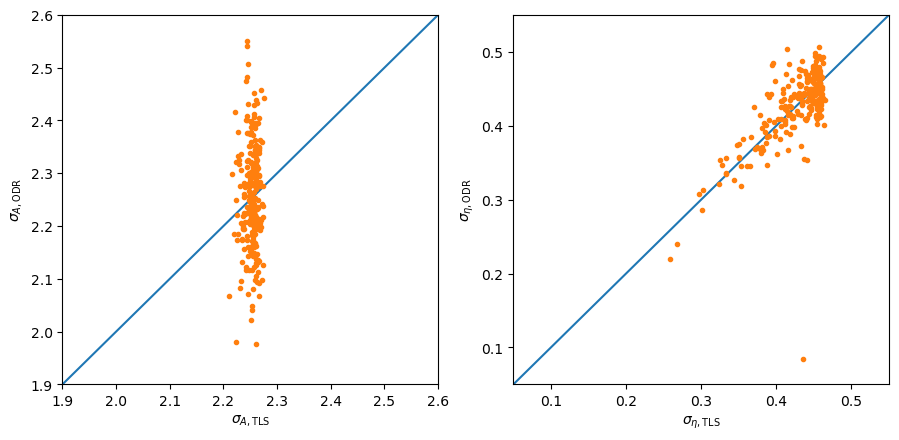

In [13]:
std_a_lim = (1.9, 2.6)
std_eta_lim = (0.05, 0.55)

w, h = figaspect(0.45)

_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(std_a_lim, std_a_lim, '-')
axs[0].plot(1e3 * sigma_tls[0,:], 1e3 * sigma_odr[0,:], '.')

axs[0].set_xlim(std_a_lim)
axs[0].set_ylim(std_a_lim)

axs[0].set_xlabel(r"$\sigma_{A,\mathrm{TLS}}$")
axs[0].set_ylabel(r"$\sigma_{A,\mathrm{ODR}}$")

axs[1].plot(std_eta_lim, std_eta_lim, '-')
axs[1].plot(1e3 * sigma_tls[1,:], 1e3 * sigma_odr[1,:], '.')

axs[1].set_xlim(std_eta_lim)
axs[1].set_ylim(std_eta_lim)

axs[1].set_xlabel(r"$\sigma_{\eta,\mathrm{TLS}}$")
axs[1].set_ylabel(r"$\sigma_{\eta,\mathrm{ODR}}$")

plt.show()

## Compare results for a single typical simulation

The cells below show that the two cost functions are slightly different, which may explain the differences between the parameter estimates obtained from the two algorithms.

In [14]:
i = i_show
print(p_tls[:, i])
print(p_odr[:, i])
print(resnorm_tls[i])
print(resnorm_odr[i])

[9.99567338e-01 4.56310853e-04]
[9.99524707e-01 4.90229455e-04]
254.483599703707
254.932485725201


In [15]:
print(np.sum(((y[i, :] - td_model(p_tls[:, i], x[i, :] + delta_odr[:, i])) / sigma) ** 2) + np.sum((delta_odr[:, i] / sigma) ** 2))
print(np.sum(((y[i, :] - td_model(p_odr[:, i], x[i, :] + delta_odr[:, i])) / sigma) ** 2) + np.sum((delta_odr[:, i] / sigma) ** 2))

254.94701966805465
254.932485725201
